# Creation of needed code for feature selection and model training

In [7]:
import pandas as pd

In [79]:
from ast import literal_eval
df = pd.read_csv('../data/dataset_initial.csv')
df['Weather_Condition_Arr'] = df['Weather_Condition_Arr'].apply(lambda x: literal_eval(x) if str(x)!='nan' else x)

In [176]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X, y = df_full[df_full.columns.drop('Severity')], df_full['Severity']

In [77]:
df

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Side,State,Temperature(F),Wind_Chill(F),...,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Weather_Condition_Arr,Wind_SN,Wind_EW
0,3,40.108910,-83.092860,40.112060,-83.031870,3.230,R,OH,42.1,36.1,...,False,False,False,Night,Night,Night,Night,[Light Rain],-0.500000,0.500000
1,2,39.865420,-84.062800,39.865010,-84.048730,0.747,R,OH,36.9,NaN,...,False,False,False,Night,Night,Night,Night,[Light Rain],0.000000,0.000000
2,2,39.102660,-84.524680,39.102090,-84.523960,0.055,R,OH,36.0,NaN,...,False,False,False,Night,Night,Night,Day,[Overcast],0.000000,0.000000
3,2,41.062130,-81.537840,41.062170,-81.535470,0.123,R,OH,39.0,NaN,...,False,False,False,Night,Night,Day,Day,[Overcast],0.000000,0.000000
4,3,39.172393,-84.492792,39.170476,-84.501798,0.500,R,OH,37.0,29.8,...,False,False,False,Day,Day,Day,Day,[Light Rain],-0.333333,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845337,2,34.002480,-117.379360,33.998880,-117.370940,0.543,R,CA,86.0,86.0,...,False,False,False,Day,Day,Day,Day,[Fair],0.000000,1.000000
2845338,2,32.766960,-117.148060,32.765550,-117.153630,0.338,R,CA,70.0,70.0,...,False,False,False,Day,Day,Day,Day,[Fair],-0.500000,0.500000
2845339,2,33.775450,-117.847790,33.777400,-117.857270,0.561,R,CA,73.0,73.0,...,False,False,False,Day,Day,Day,Day,[Partly Cloudy],-0.666667,0.333333
2845340,2,33.992460,-118.403020,33.983110,-118.395650,0.772,R,CA,71.0,71.0,...,False,False,False,Day,Day,Day,Day,[Fair],-0.500000,0.500000


## Looking at data for additional processing and encoding needed

Colums of object type - categorical variables some of them with >2 classes

In [152]:
object_cols = df.columns[df.dtypes=='object']
objects = df[object_cols]
objects

,Side,State,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Weather_Condition_Arr
0,R,OH,Night,Night,Night,Night,[Light Rain]
1,R,OH,Night,Night,Night,Night,[Light Rain]
2,R,OH,Night,Night,Night,Day,[Overcast]
3,R,OH,Night,Night,Day,Day,[Overcast]
4,R,OH,Day,Day,Day,Day,[Light Rain]
...,...,...,...,...,...,...,...
2845337,R,CA,Day,Day,Day,Day,[Fair]
2845338,R,CA,Day,Day,Day,Day,[Fair]
2845339,R,CA,Day,Day,Day,Day,[Partly Cloudy]
2845340,R,CA,Day,Day,Day,Day,[Fair]


# Feature selection and encoding

## Feature selection

Here feature selection refers to lowering categorical data cardinality and it is performed by sorting categories by frequencies and encoding first 10 as binary features while the others are encoded as separate feature labeled 'Other'.

### Weather column feature selection

Checking weather condition with multiple conditions present in the column

In [153]:
df[df['Weather_Condition_Arr'].map(lambda arr: len(arr), na_action='ignore')>1]['Weather_Condition_Arr']

231580        [Sand, Dust Whirlwinds]
457645        [Sand, Dust Whirlwinds]
526556        [Sand, Dust Whirlwinds]
705863          [Thunder, Wintry Mix]
899247        [Sand, Dust Whirlwinds]
1025171       [Sand, Dust Whirlwinds]
1039404       [Sand, Dust Whirlwinds]
1150038       [Sand, Dust Whirlwinds]
1336303       [Sand, Dust Whirlwinds]
1348807         [Thunder, Wintry Mix]
1454284       [Sand, Dust Whirlwinds]
1620037         [Thunder, Wintry Mix]
1634026         [Thunder, Wintry Mix]
1709217         [Thunder, Wintry Mix]
1729993         [Thunder, Wintry Mix]
1831010         [Thunder, Wintry Mix]
1923405         [Thunder, Wintry Mix]
2124432    [Sand, Dust Whirls Nearby]
2430583       [Sand, Dust Whirlwinds]
2812686       [Sand, Dust Whirlwinds]
2825458       [Sand, Dust Whirlwinds]
2830733       [Sand, Dust Whirlwinds]
2830734       [Sand, Dust Whirlwinds]
2830735       [Sand, Dust Whirlwinds]
2830736       [Sand, Dust Whirlwinds]
Name: Weather_Condition_Arr, dtype: object

Multiple weather condition will be also one hot encoded with multiple 1s on corresponding values

Example of top 20 weather conditions

In [154]:
from collections import Counter
from collections import OrderedDict
counts = df['Weather_Condition_Arr'].apply(lambda arr: Counter() if str(arr)=='nan' else Counter(arr)).sum()
counts = OrderedDict(counts.most_common())

<BarContainer object of 20 artists>

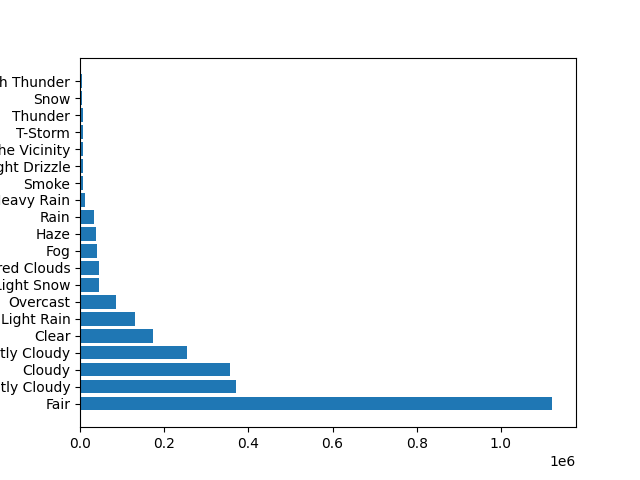

In [155]:
%matplotlib widget
import matplotlib.pyplot as plt
top_keys = list(counts.keys())[:20]
top_values = list(counts.values())[:20]
plt.barh(top_keys,top_values)

Creating custom data transformer/encoder - data is partialy encoded because it's in an array form

In [156]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter, OrderedDict

class WeatherConditionTransformator(BaseEstimator, TransformerMixin):
    def fit(self, X):
        counts = X['Weather_Condition_Arr'].apply(lambda arr: Counter() if str(arr)=='nan' else Counter(arr)).sum()
        counts = OrderedDict(counts.most_common())
        self.top_weathers = list(counts.keys())[:10]
        return self
    
    def _weather_condition_mapper(self,weather_condition_name, weather_condition_arr):
        if str(weather_condition_arr)=='nan':
            return 'False'
        if weather_condition_name =='Weather_Other':
            for w in weather_condition_arr:
                if w not in self.top_weathers:
                    return 'True'
        if weather_condition_name in weather_condition_arr:
            if weather_condition_name in self.top_weathers:
                return 'True'
        return 'False'            
            
    def transform(self, X, y=None):
        for w in self.top_weathers + ['Weather_Other']:
            mapper = lambda w_arr: self._weather_condition_mapper(w,w_arr)
            X[w] = X['Weather_Condition_Arr'].map(mapper)
        X.drop('Weather_Condition_Arr',axis='columns',inplace=True)
        return X

### States feature selection

<AxesSubplot:>

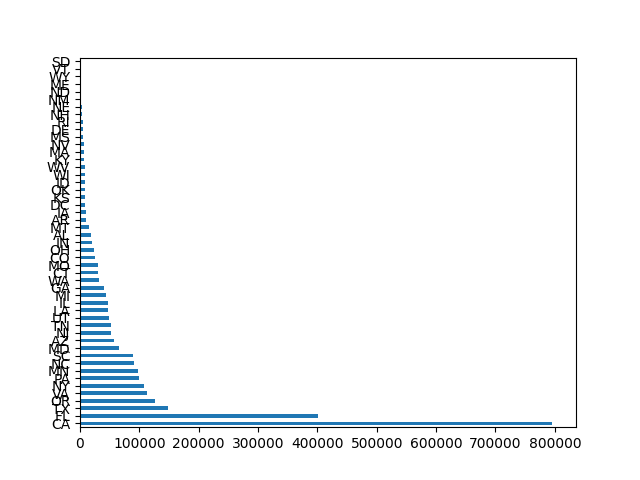

In [157]:
%matplotlib widget
df['State'].value_counts().plot(kind='barh')

In [160]:
class StateTranformator(BaseEstimator,TransformerMixin):
    def fit(self,X):
        self.top_states = X['State'].value_counts()[:10].index
        return self
        
    def _map_state(self,state):
        if state in self.top_states:
            return state
        else:
            return 'Other'
    
    def transform(self,X):
        X['State']=X['State'].map(self._map_state)
        return X


### Final feature selector

Feature selection composes of weather feature selection and state feature selection

In [161]:
class FeatureSelector(TransformerMixin):
    def __init__(self):
        self.wct = WeatherConditionTransformator()
        self.st = StateTranformator()
        
    def fit(self, X):
        self.wct.fit(X)
        self.st.fit(X)
        return self
        
    def transform(self,X):
        X = self.wct.transform(X)
        X = self.st.transform(X)
        return X
    
    def get_weather_columns(self):
        return self.wct.top_weathers + ['Weather_Other']

In [162]:
import dtale

X_sample = X.sample(100000).copy()

p = FeatureSelector()

X_sample = p.fit_transform(X_sample)
dtale.show(X_sample)

/home/eugenrudic/PycharmProjects/mt-tabnet-xgboost-model-comparison/.venv/lib/python3.10/site-packages/dtale/views.py:725: FutureWarning:

['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



## Encoding

In [163]:
class Encoder(TransformerMixin):
    def __init__(self,categorical_columns):
        self.categorical_columns=categorical_columns
    
    def fit(self,X):
        return self
    
    def transform(self,X):
        for column in self.categorical_columns:
            tempdf = pd.get_dummies(X[column], prefix=column,drop_first=True)
            X = pd.merge(
                left=X,
                right=tempdf,
                left_index=True,
                right_index=True,
            )
            X = X.drop(columns=column)
        return X

In [164]:
categorical_variables = ['Side', 'State', 'Amenity','Bump','Crossing',
                         'Give_Way', 'Junction','No_Exit',
                         'Railway','Roundabout','Station','Stop',
                         'Traffic_Calming','Traffic_Signal','Turning_Loop',
                         'Sunrise_Sunset','Civil_Twilight','Nautical_Twilight',
                         'Astronomical_Twilight']

## Final feature selection and coding example usage and results

In [165]:
X_train_sample = X.sample(100000).copy()
fs = FeatureSelector()
X = fs.fit_transform(X_train_sample)
enc = Encoder(categorical_variables + p.get_weather_columns())
dtale.show(enc.fit_transform(X))

# Creating code infrastracture for kfold validation

Using custom code is necessary to select features and encode each k-1 training fold and to ensure no spillage. As that would be the case of feature selection and encoding on whole data.

In [170]:
from sklearn.model_selection import StratifiedKFold

# TODO: change once known what is needed
class BaseTrainer():
    def __init__(self,X_train_val,Y_train_val,cat_vars,reg_vars,k=10):
        self.X_train_val=X_train_val
        self.Y_train_val=Y_train_val
        self.cat_vars=cat_vars
        self.kf = StratifiedKFold(n_splits=k)
        
    def _split_using_index(self,train_index,valid_index):
        X_train = self.X_train_val.iloc[train_index].copy()
        X_valid = self.X_train_val.iloc[valid_index].copy()
        Y_train = self.Y_train_val.iloc[train_index].copy()
        Y_valid = self.Y_train_val.iloc[valid_index].copy()
        return X_train, X_valid, Y_train, Y_valid

    def kfold_validate(self,params,test=False):
        for train_index, valid_index in self.kf.split(self.X_train_val,self.Y_train_val):
            X_train, X_valid, Y_train, Y_valid = self._split_using_index(train_index,valid_index)
            Y_train, Y_valid = self._encode_target(Y_train,Y_valid)
            X_train, X_valid = self._select_and_encode(X_train,X_valid)
            if test:
                yield X_train, X_valid, Y_train, Y_valid
            else: 
                trained_model = self._train_model(X_train,Y_train)
                validation_m = self.validate_model(trained_model,X_valid,Y_valid)
                yield validation_m
                
    def _train_model(self,params,X_train,Y_train):
        raise NotImplementedException
    
    def _validate_model(self,model):
        raise NotImplementedException
        
    def _select_and_encode(self,X_train, X_valid):
        fs = FeatureSelector()
        X_train = fs.fit_transform(X_train)
        X_valid = fs.transform(X_valid)
        encoder = Encoder(self.cat_vars+fs.get_weather_columns())
        X_train = encoder.fit_transform(X_train)
        X_valid = encoder.fit_transform(X_valid)
        return X_train,X_valid
    
    def _encode_target(self,Y_train, Y_valid):
        return Y_train-1, Y_valid-1

### Testing the given kfolds on default XGBoost classifier

In [171]:
categorical_variables = ['Side', 'State', 'Amenity','Bump','Crossing',
                         'Give_Way', 'Junction','No_Exit',
                         'Railway','Roundabout','Station','Stop',
                         'Traffic_Calming','Traffic_Signal','Turning_Loop',
                         'Sunrise_Sunset','Civil_Twilight','Nautical_Twilight',
                         'Astronomical_Twilight']

In [ ]:
import xgboost

X_train_val_sample,_, y_train_val_sample,_ = train_test_split(X,y,train_size=0.8)

bt = BaseTrainer(X_train_val_sample,y_train_val_sample,categorical_variables,[])
kfold_gen =  bt.kfold_validate({},True)

X_train,X_val,Y_train,Y_val = next(kfold_gen)

clf = xgboost.XGBClassifier()
clf.fit(X_train,Y_train)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Y_val,clf.predict(X_val))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

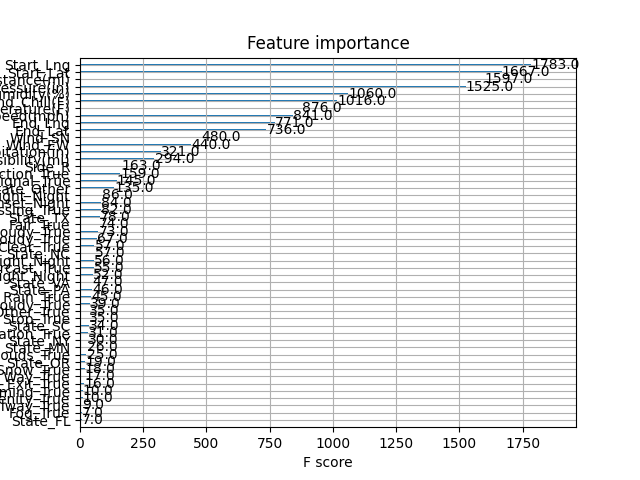

In [179]:
from xgboost import plot_importance
plot_importance(clf)

# Model specific steps

## XGBoost

In [ ]:
class XGBoostTrainer(BaseTrainer):
    def _train_model(self,params,X_train,y_train):
        model = xgboost.XGBClassifier(**params)
        model.fit(X_train,y_train)
        return model
    
    def _validate_model(self,model):
        
        raise NotImplementedException

    

## TabNet